In [1]:

import contextily
import meteostat
import shapely
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colormaps
import matplotlib.lines as mlines

def to_meteostat_point(point: shapely.Point, alt: int = None) -> meteostat.Point:
    return meteostat.Point(point.y, point.x, alt)

In [2]:
polygons_path = "../data/aux/SAIS_areaPolygons.geojson"

gdf = gpd.read_file(polygons_path)
polygons = gdf.set_index("name").to_dict("index")

# gdf.to_crs(epsg=27700, inplace=True)
# gdf["area (km^2)"] = gdf.area / 1000000
gdf["centroid"] = gdf.centroid

gdf_dict = gdf.set_index("name").to_dict("index")

In [3]:
stations_visualcrossing = pd.read_csv("../data/aux/stations_VisualCrossing_Scotland_subset.csv")
stations_visualcrossing = gpd.GeoDataFrame(stations_visualcrossing, geometry=gpd.points_from_xy(stations_visualcrossing.longitude, stations_visualcrossing.latitude))


centroid_creag_meagaidh = gdf_dict["Creag Meagaidh"]["centroid"]

retriever_meteostat = meteostat.Stations().nearby(centroid_creag_meagaidh.y, centroid_creag_meagaidh.x)
stations_meteostat = retriever_meteostat.fetch(len(stations_visualcrossing))
stations_meteostat = gpd.GeoDataFrame(stations_meteostat, geometry=gpd.points_from_xy(stations_meteostat.longitude, stations_meteostat.latitude))


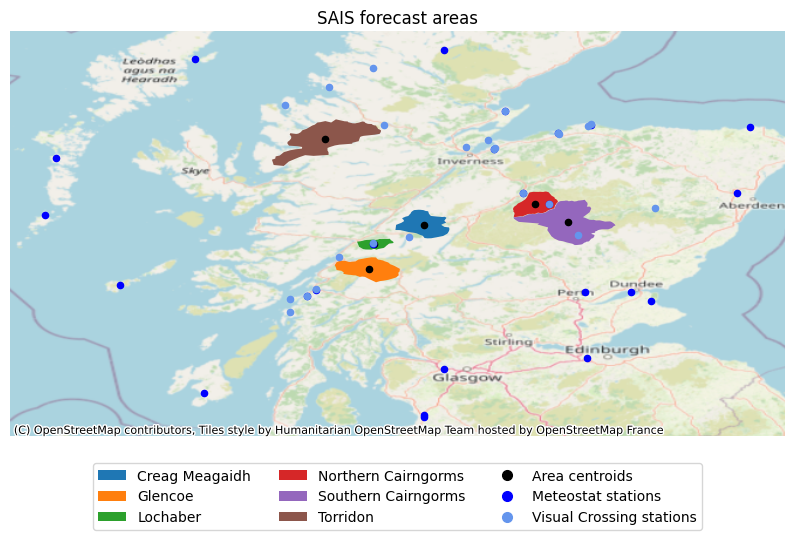

In [16]:
cmap = colormaps["tab10"]

fig, ax = plt.subplots(figsize=(10,10))
pmarks = []
i = 0
for label, data in gdf.groupby("name"):
    color = cmap(i)
    data.plot(ax=ax, color=color)
    pmarks.append(Patch(facecolor=color, label=label))
    i+=1

c_centroid = "black"
c_meteostat = "blue"
c_visualcrossing = "cornflowerblue"
dot_size = 20
gdf.geometry.centroid.plot(ax=ax, color=c_centroid, markersize=dot_size)
stations_meteostat.geometry.plot(ax=ax, color=c_meteostat, markersize=dot_size)
stations_visualcrossing.geometry.plot(ax=ax, color=c_visualcrossing, markersize=dot_size)

handles, _ = ax.get_legend_handles_labels()
pmarks.append(mlines.Line2D([], [], color=c_centroid, marker="o", linestyle="None", markersize=7, label="Area centroids"))
pmarks.append(mlines.Line2D([], [], color=c_meteostat, marker="o", linestyle="None", markersize=7, label="Meteostat stations"))
pmarks.append(mlines.Line2D([], [], color=c_visualcrossing, marker="o", linestyle="None", markersize=7, label="Visual Crossing stations"))

ax.legend(handles=[*handles,*pmarks], loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)

contextily.add_basemap(ax, crs=gdf.crs.to_string())
plt.title("SAIS forecast areas")
plt.axis("off")
plt.show()


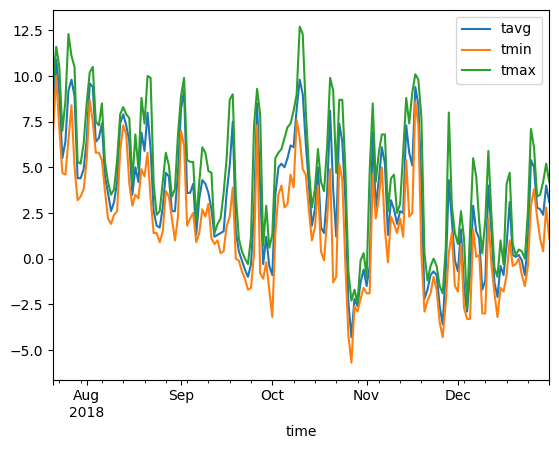

In [5]:
# Import Meteostat library and dependencies
from datetime import datetime
import matplotlib.pyplot as plt
from meteostat import Daily

# Set time period
start = datetime(2018, 1, 1)
end = datetime(2018, 12, 31)

# Create Point for Vancouver, BC
region = to_meteostat_point(gdf_dict["Creag Meagaidh"]["centroid"])

# Get daily data for 2018
data = Daily(region, start, end)
data = data.fetch()

# Plot line chart including average, minimum and maximum temperature
data.plot(y=["tavg", "tmin", "tmax"])
plt.show()


In [6]:
len(stations_meteostat)

24